In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# [Batch Normalization](https://d2l.ai/chapter_convolutional-modern/batch-norm.html)

In [2]:
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.2
  Attempting uninstall: numpy
    Found 

## Implementation from Scratch

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

As it turns out, quite serendipitously, batch normalization conveys all three benefits: preprocessing, numerical stability, and regularization.

In [4]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

In [5]:
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

In [6]:
class BNLeNetScratch(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), BatchNorm(6, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120),
            # Batch Normalization
            # 全连接层
            BatchNorm(120, num_dims=2), nn.Sigmoid(), nn.LazyLinear(84),
            BatchNorm(84, num_dims=2), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

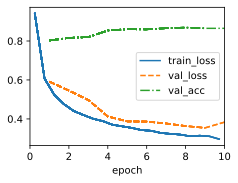

In [7]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNetScratch(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [8]:
model.net[1].gamma.reshape((-1,)), model.net[1].beta.reshape((-1,))

(tensor([1.6019, 1.6004, 1.7140, 1.7099, 2.1818, 1.9513], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([-1.7410,  0.1359,  1.3920, -1.1816,  1.5584,  0.3136], device='cuda:0',
        grad_fn=<ViewBackward0>))

## Concise Implementation

In [9]:
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))

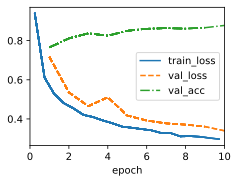

In [10]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

在深度学习中，使用 **Batch Normalization (BN)** 的主要目的是提高训练效率和稳定性，同时提升模型的性能。以下是具体原因及其原理：

------

### 1. **缓解内部协变量偏移**

#### 问题：

- 在深度神经网络中，随着层数的增加，网络中每一层的输入分布会不断变化（称为内部协变量偏移，Internal Covariate Shift），这会导致网络训练不稳定、收敛速度慢。

#### BN 的解决方式：

- BN 将每一层输入标准化为均值为 0、方差为 1 的分布，使后续层的输入分布更加稳定，减少了这种偏移现象。

------

### 2. **加速模型收敛**

- 通过标准化，BN 减少了参数更新时的不稳定性，使得梯度下降更高效。
- 实践中，BN 可以让模型使用更高的学习率，从而加快收敛速度。

------

### 3. **减少对参数初始化的敏感性**

- 深度学习模型的性能对权重初始化方法较为敏感，尤其是在深层网络中。
- BN 通过稳定输入分布，缓解了初始化对训练过程的影响，使得网络更容易找到合适的参数。

------

### 4. **减少过拟合**

- BN 的训练过程对小批量样本的统计数据进行标准化（即计算均值和方差），引入了一种正则化效果。
- 这一效果在一定程度上减少了对 Dropout 等正则化方法的依赖。

------

### 5. **原理分析**

BN 在每个 mini-batch 上进行标准化，具体公式如下：

1. **计算 mini-batch 的均值和方差：**
   $$
   \mu_B = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad \sigma_B^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_B)^2
   $$
   其中 $m$ 是 mini-batch 的样本数。

2. **标准化：**
   $$
   \hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
   $$
   $\epsilon$ 是一个小常数，用于避免除以零。

3. **引入可学习参数：**
   $$
   y_i = \gamma \hat{x}_i + \beta
   $$
   其中 $\gamma$ 和 $\beta$ 是可学习参数，用于恢复网络的表达能力。

------

### 6. **应用场景**

- **全连接层：** 在每层输入的激活值上应用 BN。
- **卷积层：** 在每个通道（channel）维度进行标准化。
- **循环网络（RNN/LSTM）：** 使用变种方法（如 Layer Normalization 或 Batch Renormalization）处理时间序列数据。

------

### 7. **潜在的缺点**

- 训练和推理差异：
  - 训练时使用 mini-batch 的统计量，推理时需要使用全局统计量。
  - 这可能引入额外的复杂性。
- 对小批量样本敏感：
  - 当 mini-batch 较小时，统计量可能不准确，导致性能下降。
- 计算开销：
  - BN 需要额外计算均值和方差，增加了一些计算成本。

------

### 8. **实际效果**

BN 的引入在许多模型中取得了显著效果，例如：

- 使得 ResNet 等深度模型能够训练更深的网络。
- 提高了模型对超参数（如学习率）的鲁棒性。

------

### 总结

Batch Normalization 是一种强大的技巧，它通过稳定输入分布、加速收敛、减少过拟合和缓解初始化敏感性，为深度学习训练提供了极大的便利。